In [2]:
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
### LOAD DATA FROM CSV INTO SQL DATABASE
DB_FILE = 'netflix.db'
# if DB file does not exist use the csv data to populate it
if not os.path.exists(DB_FILE):    
    titles = pd.read_csv('titles.csv')
    # make the database connection
    dbcon = sqlite3.connect(DB_FILE)
    # create empty tables with the correct relationships for population with the csv data
    create_titles = '''CREATE TABLE IF NOT EXISTS Titles (
                                            id TEXT PRIMARY KEY,
                                            title TEXT,
                                            type TEXT,
                                            description TEXT,
                                            release_year INTEGER,
                                            age_certification TEXT,
                                            runtime INTEGER,
                                            genres TEXT,
                                            production_countries TEXT,
                                            seasons INTEGER,
                                            imdb_id TEXT,
                                            imdb_score INTEGER,
                                            imdb_votes INTEGER,
                                            tmdb_popularity INTEGER,
                                            tmdb_score INTEGER
                                        );'''
    create_credits = '''CREATE TABLE IF NOT EXISTS Credits (
                                            person_id INTEGER NOT NULL,
                                            id TEXT NOT NULL,
                                            name TEXT NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            FOREIGN KEY (id) REFERENCES title(id)
                                        );'''
    # SMCredits is a much smaller table of credits for working with NOT A TESTING SET
    create_smcredits = '''CREATE TABLE IF NOT EXISTS SMCredits (
                                            person_id INTEGER NOT NULL,
                                            id TEXT NOT NULL,
                                            name TEXT NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            FOREIGN KEY (id) REFERENCES title(id)
                                        );'''
    cur = dbcon.cursor() # create the above empty tables
    cur.execute(create_titles)
    cur.execute(create_credits)
    # use pandas to read the data for easy storage into the SQLite db
    titles = pd.read_csv('titles.csv')
    titles.to_sql('Titles', con=dbcon, if_exists='append', index=False)
    
    credits = pd.read_csv('credits.csv')
    credits.to_sql('Credits', con=dbcon, if_exists='append', index=False)
    
    sm_credits = credits.sort_values('name')[:50]
    sm_credits.to_sql('SMCredits', con=dbcon, if_exists='append', index=False)
    
    dbcon.close()


In [4]:
# EDA
dbcon = sqlite3.connect(DB_FILE)
cur = dbcon.cursor()

cur.execute('''
SELECT imdb_score, tmdb_score FROM Titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')
cur.row_factory = lambda cursor, row: list(row)
scores = np.array(cur.fetchall()).T
#print(scores[0])
#plt.scatter(scores[0], scores[1])
print(np.cov(scores))

[[1.32556035 0.7733128 ]
 [0.7733128  1.3062808 ]]


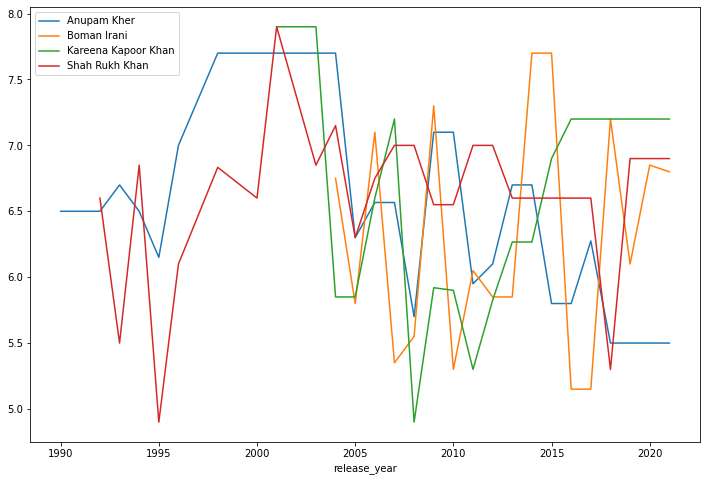

In [9]:
cur.row_factory = lambda cursor, row: list(row)

score_metric = 'tmdb_score'
star_query = '''
SELECT name, release_year, '''+score_metric+''' FROM
(
    SELECT  Credits.name, Titles.release_year, Titles.'''+score_metric+''', 
        COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
    FROM Credits
    INNER JOIN Titles ON Titles.id = Credits.id
    ORDER BY Titles.release_year
)
WHERE freq > 24
'''
star_scores = pd.read_sql_query(star_query, dbcon)
star_scores = star_scores.pivot_table(index='release_year', columns='name')
star_scores.columns = [col[1] for col in star_scores.columns]
star_scores.fillna(method='ffill', inplace=True)

plt.rcParams["figure.figsize"] = (12,8)
star_scores.plot(kind='line')

#
films_query = '''
SELECT  Credits.name, Titles.release_year, 
    COUNT(Credits.person_id) as score,
    COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
FROM Credits
INNER JOIN Titles ON Titles.id = Credits.id
GROUP BY Titles.release_year, Credits.person_id
ORDER BY score DESC
'''
#films_count = pd.read_sql_query(films_query, dbcon).dropna()

<AxesSubplot:xlabel='release_year', ylabel='AVG Score'>

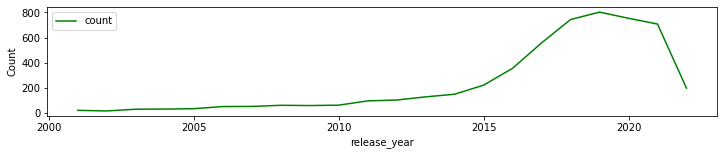

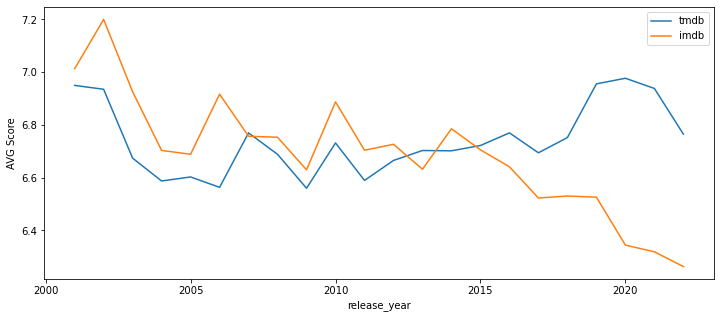

In [71]:
score_timeline = '''
SELECT release_year, count, imdb, tmdb FROM
(
    SELECT  Titles.release_year, 
        COUNT(Titles.tmdb_score) as count,
        AVG(Titles.imdb_score) as imdb,
        AVG(Titles.tmdb_score) as tmdb
    FROM Titles
    WHERE Titles.release_year > 2000
    GROUP BY Titles.release_year
    ORDER BY Titles.release_year DESC
)
'''
scores = pd.read_sql_query(score_timeline, dbcon).dropna()

plt.rcParams["figure.figsize"] = (12,2)
scores.plot(x='release_year', y=['count'], subplots=True, kind='line', ylabel='Count', color='green')

plt.rcParams["figure.figsize"] = (12,5)
scores.plot(x='release_year', y=['tmdb', 'imdb'], kind='line', ylabel='AVG Score')

In [24]:
## I decided to only to include people who appear more than twice and after 2010
## since otherwise they are not really 'up and coming'
popular_query = '''
SELECT  name, release_year, imdb_score, tmdb_score FROM
(
    SELECT  Credits.name, Titles.release_year, Titles.imdb_score, Titles.tmdb_score,
        COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
    FROM Credits
    INNER JOIN Titles ON Titles.id = Credits.id
    WHERE Titles.release_year > 2010
    ORDER BY release_year
)
WHERE freq >= 3
'''
pop_ppl = pd.read_sql_query(popular_query, dbcon).dropna()
pop_ppl = pop_ppl[pop_ppl.duplicated('name',keep=False)]
pop_ppl

,name,release_year,imdb_score,tmdb_score
0,Tamsin Greig,2011,7.1,6.7
1,Tom Kane,2011,5.4,5.8
2,Saori Hayami,2011,8.2,8.6
3,Miyu Irino,2011,8.2,8.6
4,Hiroshi Kamiya,2011,7.5,8.1
...,...,...,...,...
15491,Guillermo Lasheras,2022,5.4,7.6
15492,Ayla Satijn,2022,7.3,8.3
15493,Ayla Satijn,2022,7.3,8.3
15494,Andaç Haznedaroğlu,2022,6.4,8.0
